# CSV-Based Algorithmic Trading Backtester

We have two strategies that drive signals: 

- Moving Average Crossover: (Buys when fast simple-moving average crosses above slow; Sells on cross down) 

- Momentum: buys/sells when the return over a lookback exceeds a threshold in either direction. 

Signals are converted to orders and executed in a cash/position portfolio with occasional simulated failures.

### Imports and Config

In [26]:
%matplotlib inline

from collections import Counter
import random, os
from data_loader import load_market_data
from strategies import MovingAverageCrossover, MomentumStrategy
from engine import BacktestEngine
from reporting import compute_returns, plot_equity_curve, write_markdown_report
import pandas as pd
import matplotlib as plt



### Loading Data

In [12]:
csv_path = "market_data.csv"  
ticks = load_market_data(csv_path)
len(ticks), ticks[0], ticks[-1]


(500,
 MarketDataPoint(timestamp=datetime.datetime(2025, 9, 13, 22, 50, 11, 445376), symbol='AAPL', price=150.96),
 MarketDataPoint(timestamp=datetime.datetime(2025, 9, 13, 22, 50, 17, 545914), symbol='AAPL', price=110.92))

### Defining Strategies

In [19]:
symbol = "AAPL"
ma_params  = dict(symbol=symbol, fast=5, slow=20, qty=10)         
mom_params = dict(symbol=symbol, lookback=10, threshold=0.005, qty=5)

### Running backtests: combined, MA-only, MOM-only

In [20]:

def run_case(strategies, cash=100_000.0, fail_prob=0.01):
    eng = BacktestEngine(strategies=strategies, initial_cash=cash, fail_prob=fail_prob)
    eng.process(ticks)
    metrics = compute_returns(eng.equity_curve)
    status = Counter(o.status for o in eng.order_history)
    return eng, metrics, status


In [21]:
import random
random.seed(42)

eng_c,  m_c,  s_c  = run_case([MovingAverageCrossover(**ma_params),
                               MomentumStrategy(**mom_params)], fail_prob=0.01)
eng_ma, m_ma, s_ma = run_case([MovingAverageCrossover(**ma_params)], fail_prob=0.01)
eng_mo, m_mo, s_mo = run_case([MomentumStrategy(**mom_params)], fail_prob=0.01)

(len(eng_c.order_history), len(eng_ma.order_history), len(eng_mo.order_history))

(489, 24, 465)

### Metrics table

In [23]:
def summarize(name, metrics, status):
    return {
        "case": name,
        "total_return": metrics["total_return"],
        "sharpe_per_period": metrics["sharpe_per_period"],
        "max_drawdown": metrics["max_drawdown"],
        "fills":   status.get("FILLED", 0),
        "rejects": status.get("REJECTED", 0),
        "errors":  status.get("ERROR", 0),
    }

df = pd.DataFrame([
    summarize("combined", m_c,  s_c),
    summarize("ma_only",  m_ma, s_ma),
    summarize("mom_only", m_mo, s_mo),
])
df

,case,total_return,sharpe_per_period,max_drawdown,fills,rejects,errors
0,combined,-0.093789,-0.052174,0.131665,431,49,9
1,ma_only,-0.001561,-0.021739,0.003311,23,1,0
2,mom_only,-0.099540,-0.053172,0.138922,417,46,2


### Summarizing the metrics

- Combined portfolio:

    − Return: 9.38% 
    - Sharpe: −0.052 
    - Max DD: 13.17%, 
    - 431 fills, 49 rejects, and 9 errors.

- Moving Average Only Portfolio: 

    - Return: −0.16% 
    - Sharpe: − 0.022 
    - Max DD: 0.33%
    - 23 fills, 1 reject, 0 errors.

- Momentum Only Portfolio:
    - Return: 9.95%
    - Sharpe: −0.053
    - Max DD: 13.89%
    - 417 fills, 46 rejects, 2 errors.

*Note*: We used a fail probability of 0.01, which means that roughly 1% of orders trigger simulated execution failures. These are logged as errors and are separate from logical rejects which are due to insufficient cash/position.

We can see here that the Momentum strategy generated far more signals than the Moving Average strategy, with the combined portfolio's metrics closely resembling it. This is due to the fact that the Momentum strategy fired far more because small, noisy price moves frequently cross its simple return threshold, so it generated many signals. The MA crossover waits for smoothed averages to cross, which evidently happens far less often, so it produced far fewer fills.

### Plotting equity curves

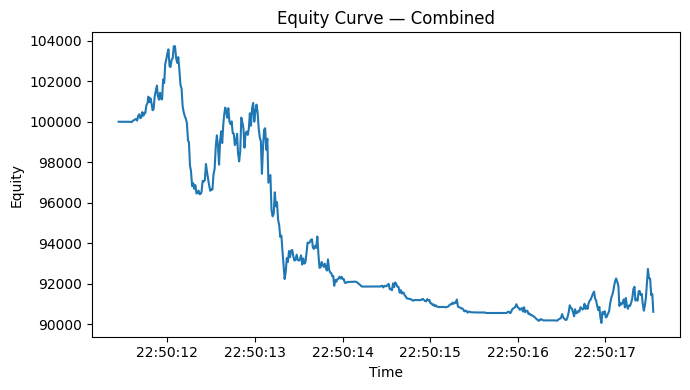

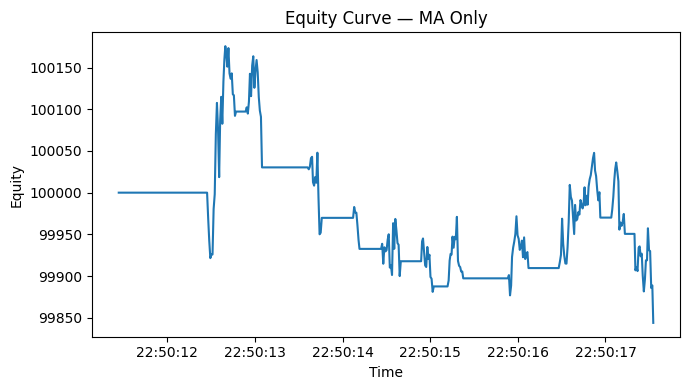

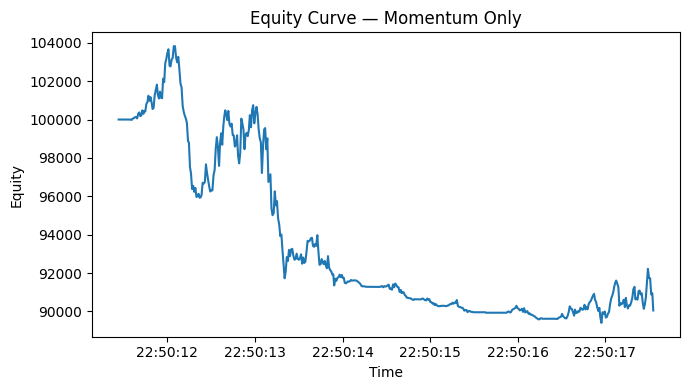

In [25]:
def plot_curve(engine, title):
    xs = [t for t, _ in engine.equity_curve]
    ys = [e for _, e in engine.equity_curve]
    plt.figure(figsize=(7,4))
    plt.plot(xs, ys)
    plt.title(title)
    plt.xlabel("Time"); plt.ylabel("Equity"); plt.tight_layout()
    plt.show()

plot_curve(eng_c,  "Equity Curve — Combined")
plot_curve(eng_ma, "Equity Curve — MA Only")
plot_curve(eng_mo, "Equity Curve — Momentum Only")

### Summarizing the curves

We can see from the curves what was already portrayed from the metrics: 

The combined equity curve is largely similar to the Momentum strategy curve. Analyzing the combined and momentum graphs (as they are essentially identical), we can see that initially the strategy performs very well, spiking up to roughly +4% returns. However, it seems a large drop quickly after and despite climbing back up around the 22:50:13 mark to roughly 0% return performance, it again quickly drops to roughly -9% returns and staganates. 

In terms of the Moving Average strategy, we can see the curve is very jagged, portraying the small amount of data points (fills) that the strategy generated. It spikes up at between 22:50:12 and 22:50:13, which is where the Momentum strategy has one of its two large drawdowns. Overall in jumps up and down around even performance until 22:50:17 where it spikes down to finish at -0.16% returns. 